In [1]:
%pylab inline
import numpy as np
import scipy
import io
import base64
from IPython.display import HTML, Image
from scipy.stats import binom, poisson
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle

## Customising the font size
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [16,8]

Populating the interactive namespace from numpy and matplotlib


# Lecture Notes Week 8

## Syllabus
1. Errors, Probabilities, and Interpretations; basics of presentation of data, mean, spread
2. Probability distributions
3. Monte Carlo basics
4. Parameter Estimation
5. Maximum Likelihood + extended maximum likelihood
6. Least Square, chi2, correlations, Best Linear Unbiased Estimator
7. **Probability and Confidence level** 
8. **Hypothesis testing**
9. Goodness of fit tests 
10. Limit setting
11. Introduction to Multivariate Analysis Techniques
12. Basics of Unfolding

## Comments up front

There has been a change in the rhythm for weekly assignments as Rene provided the assignments a bit later and was giving more relaxed timescales. I hope to get feedback from the assignments before the next set of lectures, hence the shorter period. This week's assignment should not have been overly onerous and of course all following assignments will be spaced out by a week. The next assignment is due on 18 April.

The strike period is over (at least for now) and while this course was affected, rest assured that there is a detailed assessment of the impact ongoing to ensure that no student is disadvantaged by the action taken. Last week's lectures will not be rescheduled, but you will see the main concepts introduced there reappear in today's and other lectures in the future.

## Recap

<img src="files/Confidence_90_belt.png" width=60% >
<img src="files/Confidence_90.png" width=60% >

## Confidence level

### Binomial confidence intervals

For Binomial distributions, events belong to exactly one of two classes, e.g. true or false, greater or smaller than a threshold, male or female, etc. This applies to samples of finite size and so the observed events are discretely distributed. Contrary to that the true variable is continuous, e.g. the probability for an event to be true can take any value and even the expectation value, i.e. the probability multiplied by the sample size is not necessarily an integer.

#### Recall the Binomial distribution

$$P(r;p,n)=p^r(1-p)^{n-r}\frac{n!}{r!(n-r)!},$$

where $p$ is the probability of success, $n$ is the sample size, and $r$ is the number of successes for this sample.

The expectation value is

$$<r>=np.$$

#### Construction of a Binomial confidence belt

Given that the distribution of events is discrete, the integrals used in the construction of confidence intervals have to be replaced by sums. Recall that for a central interval, for a given confidence level $C$, we have to determine 

$$\int_{-\infty}^{x_-}P(x)dx=\int_{x_+}^{\infty}P(x)dx=(1-C)/2.$$

The direct replacement would lead, for a given confidence level $C$, to

$$\sum_{r=0}^{r_-}P(r;p,n)=\sum_{r=r_+}^{n}P(r;p,n)=(1-C)/2.$$

In general the discrete nature of $r$ will prevent these equalities to be satisfied exactly. Therefore they have to be replaced by inequalities that guarantee that the confidence interval covered by the range $r_-$ to $r_+$ is _at least_ $C$. This is given by the following constructions

$$\sum_{r=0}^{r_+}P(r;p,n)\geq 1-(1-C)/2.$$

and

$$\sum_{r=r_-}^{n}P(r;p,n)\geq 1-(1-C)/2.$$

Finally, if $m$ successes are observed, the limits on the true probability can be assigned by

$$\sum_{r=m+1}^{n}P(r;p_+,n)= 1-(1-C)/2,$$

and

$$\sum_{r=0}^{m-1}P(r;p_-,n)= 1-(1-C)/2.$$

In practice, these are the outward-facing corners of the confidence belt at a position $r=m$. These are also known as the _Clopper-Pearson confidence limits_.

#### Example: Fraction of female students

In order for this excercise to be applicable to Binomial distributions, we need to work with exclusively two genders. Apologies to everyone who does not consider themselves falling into any of these categories.

Let's first establish the number of students in the course and those who are female. 

- Over to <a href="https://www.menti.com">menti.com</a> with code 94 62 50

In [2]:
nStudents = 20
nFemale = 6
cl = 0.90

#### Construction of a confidence belt based on these data

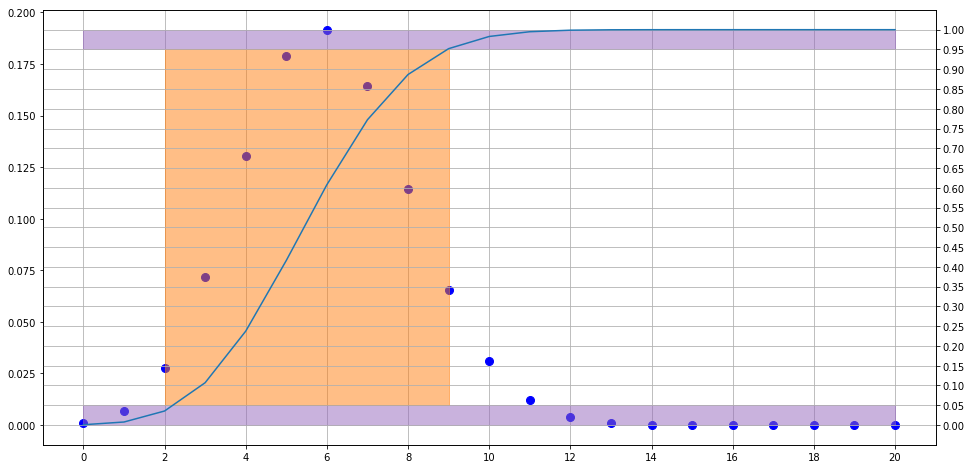

In [14]:
x = range(nStudents+1) # list of integers from 0 to nStudents
n = nStudents
p = 0.3                # example probability
limlow = (1-cl)/2      # lower limit of central confidence interval
limhigh = 1-limlow     # upper limit of central confidence interval
rv = binom(n, p)       # initialise binomial distribution
probs = rv.pmf(x)      # calculate binomial probabilities for all values of x and return list
ints = np.cumsum(probs, dtype=float) # calculate cumulative sum of probabilities

# work out limits of confidence interval based on cumulative sum of probabilities
x_low = 0
x_high = nStudents
for i in x:
    if ints[i]<limlow: x_low = i
    if ints[n-i]>limhigh: x_high = n-i

# prepare two plots with common x axis
fig,ax1 = plt.subplots()
ax1.set_xticks(x[0::2])
ax2 = ax1.twinx()

# draw two bands indicating the excluded part of the confidence level
pp = PatchCollection([Rectangle((0,0),n,limlow),Rectangle((0,limhigh),n,limlow)],alpha=0.5, color='tab:purple')

# draw a rectangle indicating the selected confidence interval
pp2 = PatchCollection([Rectangle((x_low,limlow),x_high-x_low,cl)],alpha=0.5, color='tab:orange')

# add these to the plot
ax2.add_collection(pp)
ax2.add_collection(pp2)

# plot the probability distribution
ax1.plot(x,probs, 'bo', ms=8, label='binom pmf')

# plot the cumulative integral
ax2.plot(x,ints, '-', ms=8, label='binom pmf')

# plot optics
ax2.set_yticks([x/20. for x in range(21)])
ax1.grid(which='both',axis='x')
ax2.grid(which='major',axis='y')
plt.show()


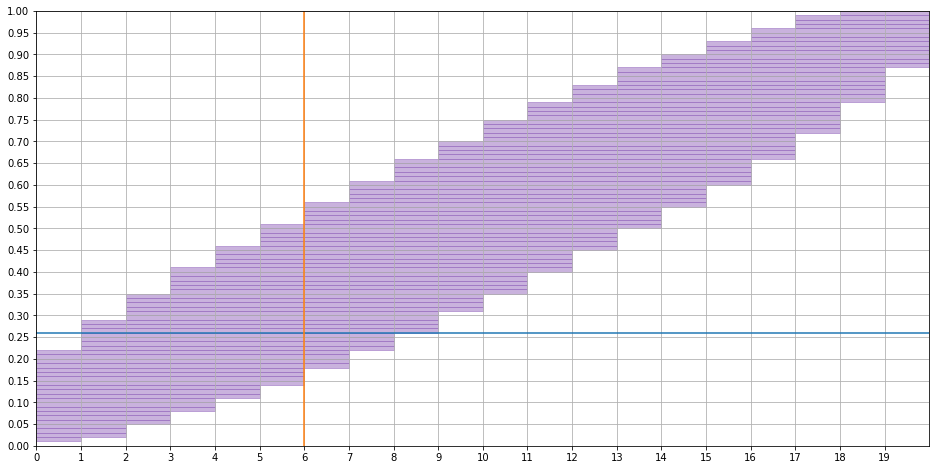

In [18]:
def binom_lower(q, n, p):
    # function to round properly when calculating confidence intervals
    rm = binom.ppf(q, n, p)
    rm1 = np.maximum(rm - 1, 0)
    return np.where( binom.cdf(rm,n,p)>q, rm1, rm)

def get_central_interval(cl, n, p):
    # calculate r- and r+ based on pre-defined functions
    rm = binom_lower(0.5*(1-cl)     , n, p)
    rp = binom.ppf(0.5*(1-cl) + cl, n, p)
    return rm, rp

def get_central_interval_details(cl, n, p):
    # calculate r- and r+ based on calculation of sums of probabilities
    sump = 0.
    summ = 0.
    foundp = False
    foundm = False
    rv = binom(n, p) # initialise binomial distribution
    for x in range(0,n+1):
        p = rv.pmf(x) # obtain probability
        sump += p
        if not foundp and 0.5*(1-cl) + cl <= sump: # check for first time exceeding threshold
            rp = x
            foundp = True
        p = rv.pmf(n-x) # obtain probability, summing up from maximum backwards
        summ += p
        if not foundm and 0.5*(1-cl) + cl <= summ: # check for first time exceeding threshold
            rm = n-x
            foundm = True
    return rm, rp

nSamples = 100 # defines granularity in y (=probability)
binom_patches = []
for i in range(1,nSamples):
    pFemale = 1. * i / nSamples # translate into probability
    #rm, rp = get_central_interval_details(0.95, nStudents, pFemale) # use detailed calculation
    rm, rp = get_central_interval(cl, nStudents, pFemale) # use fast implementation
    binom_patches.append( Rectangle((rm,pFemale),rp-rm,1./nSamples) ) # define drawing object for confidence interval
binoms = PatchCollection(binom_patches, alpha=0.5, color='tab:purple') # drawing object for complete belt

fig, ax = plt.subplots()
ax.set_xlim(0,nStudents) # set x axis range
ax.set_ylim(0,1)         # set y axis range

ax.add_collection(binoms) # draw belt

# plot optics
ax.set_yticks([x/20. for x in range(21)])
ax.set_xticks([x for x in range(nStudents)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')

# reality check
ax.plot([0,nStudents],[0.26]*2)
ax.plot([nFemale]*2,[0,1])

plt.show()


In [5]:
from scipy import special
print(cl,n,p)
vals = ceil(special.bdtrik(cl, n, p))
special.bdtr(vals-1, n, p)
binom.ppf(0.5*(1-cl),n,p)
print(binom.cdf(9,n,p)-binom.cdf(2,n,p))
binom.interval(cl,n,p)

0.9 20 0.3
0.9165549703701878


(3.0, 9.0)

### Poisson confidence intervals

The procedure for a Poisson process is rather similar to that of a Binomial distribution with the main difference that the range of possible values is not limited by a total number but goes to infinity (this is exactly how the distribution is defined, by taking the $n\to\infty$ limit of the Binomial distribution function).

#### Recall the Poisson distribution

For a given number of observed events $r$ and an expectation value of $\lambda$, the Poisson probability is given by

$$P(r;\lambda)=\frac{e^{-\lambda}\lambda^r}{r!}.$$

#### Construction of Poisson intervals

A 90% upper limit is therefore given by the value $N_+$ for which

$$\sum_{r=n+1}^\infty P(r;N_+)=0.90.$$

This is equivalent to

$$\sum_{r=0}^n P(r;N_+) = 1 - 0.90 = 0.10,$$

which may be easier to calculate.

One useful number to remember is the 90% upper limit for the case that the number of observed events is 0; this limit is $N_+=2.3$. Hence, in any counting experiment that yields an obervation of 0, we can be 90% sure that the true number of events is no greater than $2.3$.

Accordingly, the 90% lower limit is given by

$$\sum_{r=0}^{n-1} P(r;N_-) = 0.90.$$



### Confidence intervals for several variables: confidence regions

In the case of several variables the confidence intervals does not apply directly, e.g. in the case of two variables, the parameter space corresponding to a certain confidence level is not given by independent intervals in the individual variables, which would result in a rectangular area in parameter space, but rather by a more complex confidence region.

In the case of Gaussian uncertainties, the confidence region in two dimensions is an ellipse. However, this can take more complicated shapes depending on how the parameters are determined and on whether Gaussian uncertainties apply.

In general, the maximum likelihood method provides a straghtforward way of constructing confidence regions as the likelihood is multiplicative and hence the likelihood defining the confidence region is the product of the likelihoods of the individual vairables, potentially accounting for correlations.

One caveat applies regarding the confidence level of a multi-dimensional region compared to a one-dimensional interval. As illustrated below, the ellispe spanned by the 1D 68% confidence-level intervals, i.e. the standard deviations of the measurements, contains only 39% confidence level as the remainder is covered in infinitely long  bands limited only in one variable. It is therefore essential to state the coverage of any multi-dimensional confidence region to avoid confusion and mistakes.

<img src="files/2D_confidence_contours.png" width=60% >

Below are a few real-life examples of more comlicated confidence contours. These are taken from my work in the <a href="https://hflav.web.cern.ch">Heavy Flavor Averaging Group</a> and more details for those who want it can be found on the linked web page, where these particular examples refer to _charm physics_.

<img src="files/direct_indirect_cpv_Autumn16_HFLAV.png" width=60%>
<img src="files/CPV_combination_explained.png" width=60%>
<img src="files/Mixing_combination_explained.png" width=60%>

## Hypothesis testing

Regarding the lecture notes for this part, please refer to the visualiser copies on blackboard for the moment.

Below is an example of two Poisson distributions that were used in the lecture to illustrate composite hypotheses.

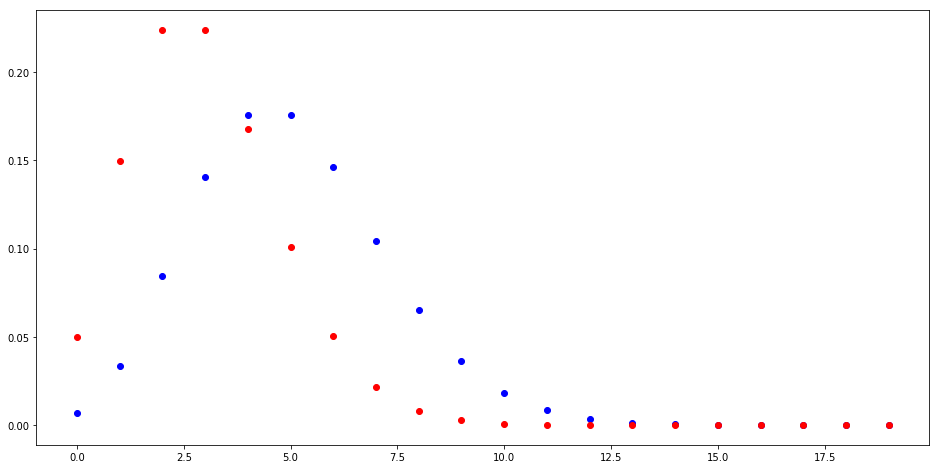

In [19]:
p5 = poisson(5)
p3 = poisson(3)
x = range(20)
pp5 = p5.pmf(x)
pp3 = p3.pmf(x)

plot(x,pp5,'bo')
plot(x,pp3,'ro')